# Clasificaión Manual de flores

Mariana Michell Flores Monroy

En el clasificador anterior, usabamos un modelo de red neuronal que ya venía entrenado, ya sea resnet18 o resnet34. Pero esta vez vamos a implementar un modelo de red neuronal manualmente.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

En este caso vamos a importar más bibliotecas en comparación con ejercicios anteriores. Ahora vamos a utilizar torch

In [2]:
import fastai as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc #sirve para liberar la memoria
from pathlib import Path

Tomamos la carpeta de flowers y la ponemos en una variable, y le hacemos transformaciones a las imagenes (como el clasficiador pasado).

In [3]:
flowers = Path("flowers")

In [4]:
transformacion = fv.get_transforms(flip_vert = True, max_rotate = 360)

Ahora vamos a usar la "forma fea" de cargar los datos, crearemos una funcion que reciba como parametros la carpeta a usar, el tamaño que queremos de las imágenes, y el tamaño de batch a usar.
Para esto vamos a usar el método ImageItemList para crear una lista con las imágenes y así poder hacer transformaciones y recortarlas (algo similar a lo que se hizo con el clasificador de mascotas). 

In [5]:
def cargar_datos(folder, img_size, batch_size):
    datos = (fv.ImageItemList.from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(transformacion, size = img_size)
            .databunch(bs = batch_size))
    return datos

In [6]:
datos_flores = cargar_datos(flowers, img_size = 192, batch_size = 80)

Como Pytorch no tiene ciertas funciones, se las tenemos que agregar a manita.

Flatten: Sirve para conectar capas convlcionales con las lineales.
num_params: Sirve literalmente para ver el numero de parametros que tiene nuestro modelo.

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.squeeze() #solo llama a la función squeeze para "aplastar" las imagenes

def num_params(modelo):
    total=0
    for p in list(modelo.parameters()):
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

Es hora de crear nuestro primer modelo de red.

Conv2d: Genera una capa convulcional en 2 dimensiones.

ReLU: Función de activación.

MaxPool2d: No recuerdo qué hace.

In [8]:
modelo = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 192, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 384, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh(),
            fv.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(384*2, 256),
            nn.LeakyReLU(inplace = True),
            nn.Linear(256, 102))
modelo

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Tanh()
  (14): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (15): Flatten()
  (16): Linear(in_features=768, out_features=256,

In [9]:
num_params(modelo) #vemos el numero de parametros que tiene nuestro modelo

1855526

Creamos nuestro learner dando nuestro modelo como parametro

In [10]:
learner = fv.Learner(datos_flores, modelo, metrics = fai.metrics.accuracy, wd = 0.1)

In [11]:
gc.collect() #limpiamos memoria

0

In [12]:
learner.summary() # damos una vista rápida a la arquitectura del modelo. 
#Lo pondré en un Raw NBConvert ya que la salida es muy fea y casi no se entiende

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [80, 64, 96, 96]     9472       True      \n______________________________________________________________________\nReLU                 [80, 64, 96, 96]     0          False     \n______________________________________________________________________\nMaxPool2d            [80, 64, 48, 48]     0          False     \n______________________________________________________________________\nConv2d               [80, 128, 48, 48]    73856      True      \n______________________________________________________________________\nReLU                 [80, 128, 48, 48]    0          False     \n______________________________________________________________________\nMaxPool2d            [80, 128, 24, 24]    0          False     \n________________________________________

Ahora trataremos de encontrar una taza de aprendizaje "decente". Y ese resultado lo usaremos en el fit_one_cycle.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


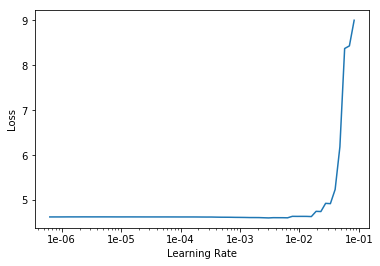

In [13]:
learner.lr_find(); learner.recorder.plot()

In [14]:
learner.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,4.290831,4.002775,0.043478
2,3.673901,3.356787,0.150198
3,3.203165,3.072196,0.197628


Una vez que lo entrenamos volvemos a sacar una gráfica de learning rate para sacar la nueva taza de aprendizaje

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


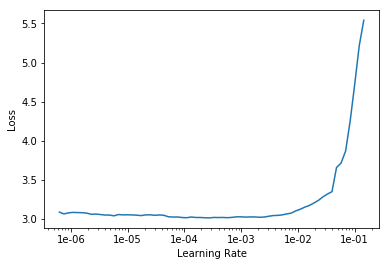

In [15]:
learner.lr_find(); learner.recorder.plot()

In [16]:
learner.fit_one_cycle(10, 7e-4) #ponemos el mejor leaning rate

epoch,train_loss,valid_loss,accuracy
1,3.012267,3.029344,0.197628
2,2.971432,2.940127,0.239130
3,2.901617,2.899018,0.201581
4,2.787291,2.716493,0.247036
5,2.651374,2.593771,0.302372
6,2.520230,2.486593,0.320158
7,2.413574,2.406152,0.349802
8,2.302616,2.366841,0.357708
9,2.221081,2.312186,0.359684
10,2.189527,2.308686,0.369565


Y repetimos el proceso

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


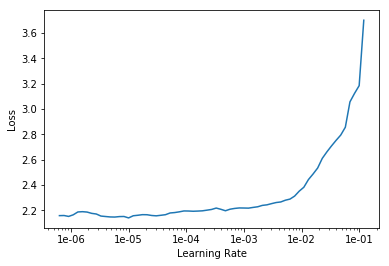

In [17]:
learner.lr_find(); learner.recorder.plot()

In [18]:
learner.fit_one_cycle(10, 2e-4)

epoch,train_loss,valid_loss,accuracy
1,2.202538,2.305443,0.357708
2,2.209146,2.292401,0.367589
3,2.212477,2.270036,0.385375
4,2.189735,2.254205,0.375494
5,2.128154,2.224626,0.381423
6,2.100861,2.176476,0.401186
7,2.049931,2.139974,0.407115
8,2.001894,2.128546,0.411067
9,1.994279,2.120476,0.409091
10,1.969211,2.122185,0.411067


# ¿Cómo mejorar nuestro modelo?

Como nuestro modelo no da buenos resultados tenemos que mejorar ciertos aspectos como el Transfer learning, el BatchNorm, Resnet y poner más capas

### Batch norm

Esta función se puede agregar directamente en modelo que hicimos anteriormente, pero sería más complicado de entender. 

La idea de esta función es poner la activión y el batchnorm antes de las capas convulcionales.

In [19]:
def conv_block(ni, no, k = 3, s = 1, pad = "same", bn = True, activation = True, g = 1):
    if pad == "same": 
        pad = k//2
    
    layers = []
    
    if bn:
        layers += [nn.BatchNorm2d(ni)]
       
    if activation:
        layers += [nn.LeakyReLU(inplace = True)] 
    
    layers += [nn.Conv2d(ni, no, kernel_size = k, stride=s, padding=pad, bias = not bn, groups=g)]
    
    return nn.Sequential(*layers)

Rehacemos el modelo agregando la función que acabamos de hacer, pero en la primera linea activation = False es para que no entre la activación directamente

In [20]:
modelo = nn.Sequential(
            conv_block(3, 64, k = 7, s = 2, activation = False, bn = False),
            nn.MaxPool2d(2),
            conv_block(64, 128),
            nn.MaxPool2d(2),
            conv_block(128, 192),
            nn.MaxPool2d(2),
            conv_block(192, 256),
            nn.MaxPool2d(2),
            conv_block(256, 384),
            nn.Tanh(),
            fv.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2*384, 256),
            nn.LeakyReLU(inplace = True),
            nn.Linear(256, 102)
        )
num_params(modelo)

1855846

In [21]:
learner = fv.Learner(datos_flores, modelo, metrics = fai.metrics.accuracy, wd = 0.05) #creamos otra vez el learner con el nuevo modelo

In [22]:
gc.collect() #limpia la memoria

21199

In [23]:
learner.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [80, 64, 96, 96]     9472       True      \n______________________________________________________________________\nMaxPool2d            [80, 64, 48, 48]     0          False     \n______________________________________________________________________\nBatchNorm2d          [80, 64, 48, 48]     128        True      \n______________________________________________________________________\nLeakyReLU            [80, 64, 48, 48]     0          False     \n______________________________________________________________________\nConv2d               [80, 128, 48, 48]    73728      True      \n______________________________________________________________________\nMaxPool2d            [80, 128, 24, 24]    0          False     \n________________________________________

Vamos a repetir el proceso anterior para seleccionar una learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


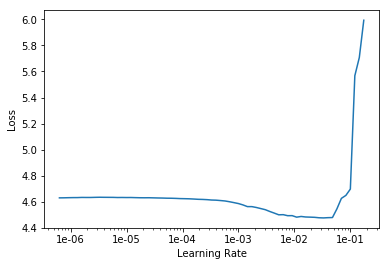

In [24]:
learner.lr_find(); learner.recorder.plot()

In [25]:
learner.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,3.757950,5.948403,0.047431
2,3.264836,3.038846,0.195652
3,2.765366,2.628155,0.298419


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


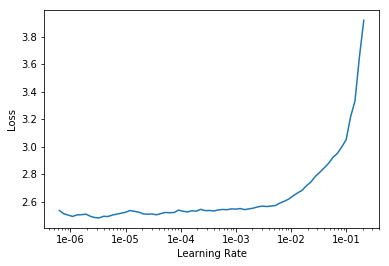

In [26]:
learner.lr_find(); learner.recorder.plot()

In [27]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.552995,2.595283,0.304348
2,2.536668,3.140568,0.185771
3,2.436813,2.412382,0.339921
4,2.295905,2.494361,0.326087
5,2.107307,2.080354,0.407115
6,1.975979,1.927286,0.454545
7,1.826232,1.862377,0.484190
8,1.719906,1.713705,0.503953
9,1.649345,1.683656,0.519763
10,1.589234,1.667149,0.519763


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


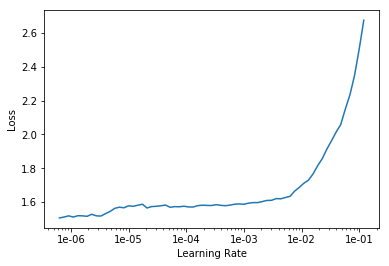

In [28]:
learner.lr_find(); learner.recorder.plot()

In [29]:
learner.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy
1,1.585728,1.666092,0.515810
2,1.566991,1.659719,0.521739
3,1.590261,1.663107,0.519763
4,1.574344,1.653253,0.525692
5,1.564682,1.652999,0.525692
6,1.583729,1.656952,0.519763
7,1.563596,1.654767,0.517787
8,1.566849,1.659501,0.521739
9,1.567916,1.663874,0.511858
10,1.570907,1.657868,0.523715


Ahora checamos el número de parametros y lo comparamos con el número de parametros que tiene resnet18 y vemos que si es considerablemente más bajo.

In [30]:
print(num_params(fv.models.resnet18()))
num_params(fv.models.resnet18())/num_params(modelo)

11689512


6.29875108171691

### Resnets

Para mejorar el rendimiento, vamos a "saltar conexiones". Es decir, vamos a guardar el resultado de una capa y vamos a sumarla, pero un par de capas depues en vez de sumarla a la siguiente y así sucesivamente. (No logro entender muy bien lo que hace la clase Downscale)

In [31]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        
        layers = [conv_block(nf, nf, k = 3),
                  conv_block(nf, nf)]
        self.residual = nn.Sequential(*layers)
        
    def forward(self, x):
        return x + self.residual(x)

In [32]:
class Downscale(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        
        self.ap = nn.AvgPool2d(2)
        self.mp = nn.MaxPool2d(2)
        self.conv = conv_block(2*ni,no,ks = 1,s = 1,pad = 0)
         
    def forward(self, x):
        return self.conv(torch.cat((self.ap(x), self.mp(x)), dim = 1))

In [33]:
def resnet_body(filters):
    layers = [conv_block(3, filters[0], k = 7, s = 2, activation = False)]
    
    for ni, no in zip(filters[:-1], filters[1:]):
        layers += [nn.MaxPool2d(2), ResBlock(ni), conv_block(ni, no, g = 1 + (no > 150))]
        
    return layers

Ahora tomamos las funciones que acabamos de hacer, y las utilizaremos para crear un nuevo modelo.

In [44]:
layers = resnet_body([64, 96, 128, 192, 256])
layers += [nn.Tanh(),
          fv.AdaptiveConcatPool2d(),
          Flatten(),
          nn.Dropout(0.5), # es el porcentaje de neuronas que se "desconectan" en cada iteración
          nn.Linear(512, 256),
          nn.Dropout(0.2),
          nn.LeakyReLU(inplace = True),
          nn.Linear(256, 102)]

modelo = nn.Sequential(*layers)

Y repetimos el proceso

In [45]:
num_params(modelo)

1865580

In [46]:
learner = fv.Learner(datos_flores, modelo, wd=0.1, metrics=fai.metrics.accuracy)

In [47]:
gc.collect()

8

In [48]:
learner.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nBatchNorm2d          [80, 3, 192, 192]    6          True      \n______________________________________________________________________\nConv2d               [80, 64, 96, 96]     9408       True      \n______________________________________________________________________\nMaxPool2d            [80, 64, 48, 48]     0          False     \n______________________________________________________________________\nBatchNorm2d          [80, 64, 48, 48]     128        True      \n______________________________________________________________________\nLeakyReLU            [80, 64, 48, 48]     0          False     \n______________________________________________________________________\nConv2d               [80, 64, 48, 48]     36864      True      \n________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


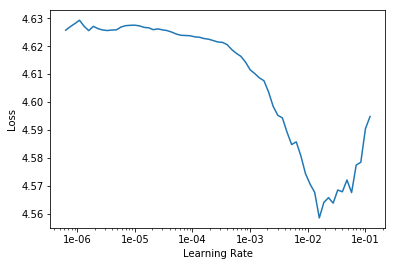

In [49]:
learner.lr_find(); learner.recorder.plot()

In [50]:
learner.fit_one_cycle(5,8e-3)

epoch,train_loss,valid_loss,accuracy
1,4.097019,3.991101,0.059289
2,3.699608,3.488452,0.134387
3,3.426150,3.229809,0.132411
4,3.104651,2.761539,0.264822
5,2.830434,2.613357,0.302372


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


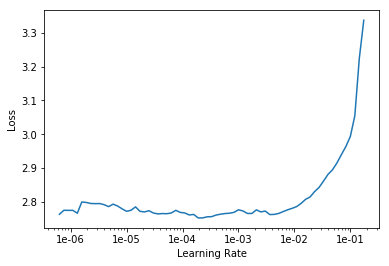

In [51]:
learner.lr_find(); learner.recorder.plot()

In [52]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.735577,2.583660,0.322134
2,2.716100,2.541962,0.335968
3,2.677280,2.471160,0.318182
4,2.569270,2.272358,0.359684
5,2.472403,2.222190,0.373518
6,2.371817,2.087164,0.399209
7,2.261433,1.995647,0.411067
8,2.209196,1.942661,0.440711
9,2.143509,1.904836,0.444664
10,2.115278,1.897693,0.438735


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


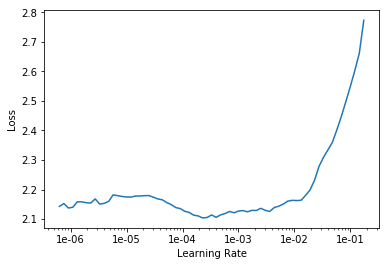

In [53]:
learner.lr_find(); learner.recorder.plot()

In [54]:
learner.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy
1,2.132805,1.922086,0.446640
2,2.194335,2.059858,0.407115
3,2.272529,2.186700,0.381423
4,2.196688,2.160845,0.413043
5,2.098623,1.832508,0.450593
6,1.974584,1.775446,0.468379
7,1.851166,1.687238,0.500000
8,1.743793,1.543222,0.525692
9,1.652952,1.479698,0.559289
10,1.606088,1.468220,0.553360


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


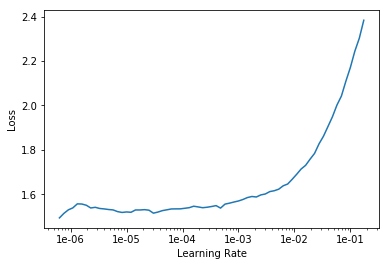

In [55]:
learner.lr_find(); learner.recorder.plot()

In [56]:
learner.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.592406,1.470666,0.553360
2,1.657912,1.583488,0.537549
3,1.693929,1.633249,0.523715
4,1.651361,1.533985,0.541502
5,1.571359,1.393005,0.584980
6,1.483645,1.354133,0.584980
7,1.411529,1.301276,0.588933
8,1.370319,1.296842,0.620553


Como ya llegamos al accuracy que se nos pide, guardamos el modelo

In [58]:
learner.save('manual-resnet62')

In [59]:
learner.fit_one_cycle(8,8e-4) #este nos da un ligero mejor resultado

epoch,train_loss,valid_loss,accuracy
1,1.354857,1.377383,0.584980
2,1.422372,1.390977,0.579051
3,1.458832,1.553877,0.543478
4,1.408418,1.380068,0.588933
5,1.363174,1.317883,0.583004
6,1.282569,1.204461,0.618577
7,1.220590,1.185251,0.626482
8,1.176774,1.176781,0.642292


In [60]:
learner.save('manual-resnet64')

# Conclusiones

Como fue obvio, crear una red neuronal desde cero es bastante complicado y pesado. Sobre todo a la hora de ver qué le podíamos optmizar, el learning rate más adecuado, el número de parametros etc.

En resumen, es muy complicado hacer redes artesanalmente ya que tenemos que ir checando paso por paso cómo está trabajando y qué se le puede mejorar. 

Mejor hay que usar redes preentrenadas en la vida real.